# MST implementato tramite PLI

## Import delle librerie

In [166]:
from math import floor, log2
import matplotlib.pyplot as plt
import networkx as nx
from pyqubo import Binary, Placeholder, Constraint
from neal import SimulatedAnnealingSampler
from itertools import chain, combinations

## Lettura dell'input

Formato del file atteso:

```text
vertex0,...,vertexN
source1,target1,weight1
...
sourceN,targetN,weightN
```

In [262]:
edges = {}
with open('3v_3e.txt') as f:
    lines = [l.strip() for l in f.readlines()]
    nodes = {int(v) for v in lines[0].split(',')}
    for e in lines[1:]:
        vals = [int(x) for x in e.split(',')]
        edges[(vals[0], vals[1])] = vals[2]

## Visualizzazione tramite NetworkX

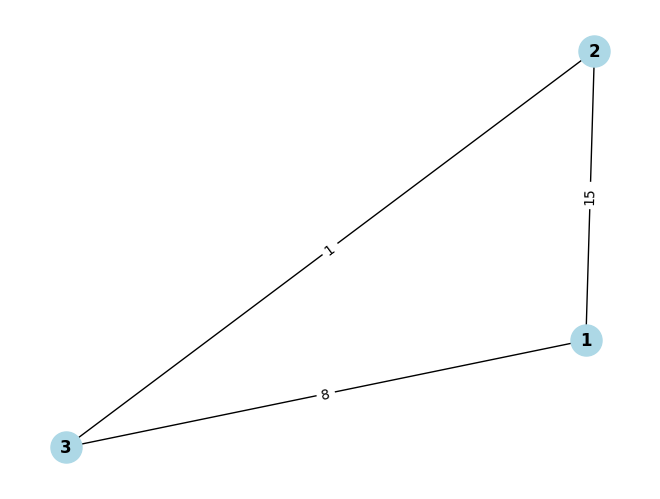

In [263]:
graph = nx.Graph()
for n in nodes:
    graph.add_node(n)
for edge, w in edges.items():
    graph.add_edge(edge[0], edge[1], weight=w)
edge_labels = nx.get_edge_attributes(graph, 'weight')

pos = nx.spring_layout(graph, k=5)
nx.draw(graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.show()

## Martin's solution

### Creazione delle variabili binarie

Le variabili binarie sono salvate in un dizionario `etichetta: variabili` per poter essere recuperate dinamicamente durante la creazione dei vincoli.

#### Interpretazione delle variabili binarie

$$x_{ij} = \begin{cases}
    0 & (i, j) \notin \text{archi MST} \\
    1 & (i, j) \in \text{archi MST}
\end{cases}$$

Ipotizzando di rimuovere l'arco $(i, j)$ da MST, allora:
$$y_{ij}^k = \begin{cases}
    0 & k\ \text{è connesso a i} \\
    1 & k\ \text{è connesso a j}
\end{cases}$$
Discorso analogo per $y_{ji}^k$.

In [272]:
bin_vars = {f'x_{e[0]}_{e[1]}': Binary(f'x_{e[0]}_{e[1]}') for e in edges}

for s, t in edges.keys():
    for n in nodes:
        bin_vars[f'y_{s}_{t}^{n}'] = Binary(f'y_{s}_{t}^{n}')
        bin_vars[f'y_{t}_{s}^{n}'] = Binary(f'y_{t}_{s}^{n}')

for s, t in edges.keys():
    for n in nodes.difference({s, t}):
        bin_vars[f'y_{s}_{n}^{t}'] = Binary(f'y_{s}_{n}^{t}')

### Funzione obiettivo

$$\min_{x, y} \sum_{(i, j) \in E}\phi_{ij}x_{ij}$$

In [273]:
obj = sum(w * bin_vars[f'x_{e[0]}_{e[1]}'] for e, w in edges.items())

### Vincoli del problema

#### Vincolo 1

$$\sum_{(i,j) \in E} x_{ij} = n-1$$

L'albero deve avere esattamente $n-1$ archi.

In [274]:
constraint_1 = Constraint((sum(bin_vars[f'x_{e[0]}_{e[1]}'] for e in edges) - len(nodes) + 1) ** 2,
                          label='constraint_1', condition=lambda x: x==0)

#### Vincolo 2

$$y_{ij}^k + y_{ji}^k = x_{ij}, \forall (i, j) \in E, k \in V$$

Se $x_{ij} = 1, \forall k \in V, k \in$ *lato* di $i$ o di $j$.

In [275]:
constraints_2 = []
i = 1
for s, t in edges.keys():
    for n in nodes:
        constraints_2.append(
            Constraint((
                        bin_vars[f'y_{s}_{t}^{n}'] +
                        bin_vars[f'y_{t}_{s}^{n}'] -
                        bin_vars[f'x_{s}_{t}']) ** 2,
                        label=f'constraint_2_{i}', condition=lambda x: x==0))
        i += 1

#### Vincolo 3

$$\sum_{k\in V \setminus \{i, j\}}y_{ik}^j+x_{ij} = 1, \forall (i, j) \in E$$

Se $x_{ij} = 1$ tutti gli altri nodi sono connessi a $i$.

In [276]:
constraints_3 = [
    Constraint((sum(bin_vars[f'y_{s}_{n}^{t}'] for n in nodes.difference({s, t})) + bin_vars[f'x_{s}_{t}'] - 1) ** 2,
        label=f'constraint_3_{i}', condition=lambda x: x==0
    )
    for i, (s, t) in enumerate(edges.keys(), start=1)
]

In [277]:
print(f'G({len(nodes)}, {len(edges)})\nMartin\'s formulation: {1 + len(constraints_2) + len(constraints_3)} vincoli')

G(3, 3)
Martin's formulation: 13 vincoli


### Creazione dell'equazione QUBO

In [278]:
lagrange = Placeholder('L')
ham_function = obj + lagrange * constraint_1 \
               + sum(lagrange * c2 for c2 in constraints_2) \
               + sum(lagrange * c3 for c3 in constraints_3)
bqm = ham_function.compile().to_bqm(feed_dict={'L': 10})

### Risoluzione tramite Simulated Annealing

In [279]:
simulated_annealing = SimulatedAnnealingSampler()
sample_set = simulated_annealing.sample(bqm, num_reads=15, num_sweeps=100)
print('Sample set:\n', sample_set)
print('\nPrimo sample:')
print(sample_set.first)

Sample set:
    x_1_2 x_1_3 x_2_3 y_1_2^1 y_1_2^2 y_1_2^3 y_1_3^1 ... y_3_2^3 energy num_oc.
1      0     1     1       0       0       0       0 ...       0    9.0       1
2      0     1     1       0       0       0       1 ...       1    9.0       1
4      0     1     1       0       0       0       1 ...       0    9.0       1
6      0     1     1       0       0       0       0 ...       1    9.0       1
8      0     1     1       0       0       0       0 ...       0    9.0       1
12     0     1     1       0       0       0       0 ...       0    9.0       1
13     0     1     1       0       0       0       1 ...       1    9.0       1
0      1     0     1       1       1       1       0 ...       0   16.0       1
3      1     0     1       1       0       1       0 ...       1   16.0       1
5      1     0     1       0       1       1       0 ...       1   16.0       1
7      1     0     1       0       0       1       0 ...       0   16.0       1
9      1     0     1       

## Cut-Set

### Creazione delle variabili binarie

Le variabili binarie sono salvate in un dizionario `etichetta: variabili` per poter essere recuperate dinamicamente durante la creazione dei vincoli.

#### Interpretazione delle variabili

$$x_{ij} = \begin{cases}
    0 & (i, j) \notin \text{archi MST} \\
    1 & (i, j) \in \text{archi MST}
\end{cases}$$

In [280]:
bin_vars_cut = {f'x_{e[0]}_{e[1]}': Binary(f'x_{e[0]}_{e[1]}') for e in edges}

### Funzione obiettivo

$$\min_{x, y} \sum_{(i, j) \in E}\phi_{ij}x_{ij}$$

In [281]:
obj_cut = sum(w * bin_vars_cut[f'x_{e[0]}_{e[1]}'] for e, w in edges.items())

### Vincoli del problema

#### Vincolo 1

$$\sum_{(i,j) \in E} x_{ij} = n-1$$

L'albero deve avere esattamente $n-1$ archi.

In [282]:
constraint_1_cut = Constraint((sum(bin_vars_cut[f'x_{e[0]}_{e[1]}'] for e in edges) - len(nodes) + 1) ** 2,
                              label='constraint_1', condition=lambda x: x==0)

#### Vincolo 2

$$\sum_{i \in S, j \in V\setminus S}x_{ij} \geq 1, \forall\ \emptyset \subset S \subset V$$

$$\sum_{i \in S, j \in V\setminus S}x_{ij} - s_1= 1, \forall\ \emptyset \subset S \subset V$$

$$0 \leq s_1 \leq |E| - 1$$

In [283]:
def powerset(elements):
    return list(chain.from_iterable(combinations(elements, r) for r in range(len(elements)+1)))

In [284]:
from random import randint
constraints_2_cut = []
i = 1
for s in powerset(nodes)[1:-1]:
    x_sum = 0
    for i in s:
        for j in nodes.difference(s):
            if f'x_{i}_{j}' in bin_vars_cut:
                x_sum += bin_vars_cut[f'x_{i}_{j}']
            elif f'x_{j}_{i}' in bin_vars_cut:
                x_sum += bin_vars_cut[f'x_{j}_{i}']
    mult = 1
    y_sum = 0
    for idx in range(floor(log2(len(edges))) + 1):
        y_sum += mult*Binary(f'y_{randint(0, 10_000)}')
        mult *= 2
    constraints_2_cut.append(Constraint((x_sum - y_sum - 1) ** 2,
                                        label=f'constraint_2_{i}', condition=lambda x: x==0))
    i += 1

In [285]:
print(f'G({len(nodes)}, {len(edges)})\nCut-Set: {1 + len(constraints_2_cut)} vincoli')

G(3, 3)
Cut-Set: 7 vincoli


### Creazione dell'equazione QUBO

In [286]:
lagrange = Placeholder('L')
ham_function = obj_cut + lagrange * constraint_1_cut + sum(lagrange * c2 for c2 in constraints_2_cut)
bqm = ham_function.compile().to_bqm(feed_dict={'L': 10})

### Risoluzione tramite Simulated Annealing

In [287]:
simulated_annealing = SimulatedAnnealingSampler()
sample_set = simulated_annealing.sample(bqm, num_reads=15, num_sweeps=100)
print('Sample set:\n', sample_set)
print('\nPrimo sample:')
print(sample_set.first)

Sample set:
    x_1_2 x_1_3 x_2_3 y_1 y_1264 y_1272 y_2225 y_4828 ... y_9414 energy num_oc.
0      0     1     1   0      1      0      0      0 ...      0    9.0       1
1      0     1     1   0      1      0      0      0 ...      0    9.0       1
2      0     1     1   0      1      0      0      0 ...      0    9.0       1
4      0     1     1   0      1      0      0      0 ...      0    9.0       1
5      0     1     1   0      1      0      0      0 ...      0    9.0       1
6      0     1     1   0      1      0      0      0 ...      0    9.0       1
7      0     1     1   0      1      0      0      0 ...      0    9.0       1
8      0     1     1   0      1      0      0      0 ...      0    9.0       1
9      0     1     1   0      1      0      0      0 ...      0    9.0       1
11     0     1     1   0      1      0      0      0 ...      0    9.0       1
13     0     1     1   0      1      0      0      0 ...      0    9.0       1
3      1     0     1   0      0      0 